#Goal: Train a logistic regression model in line with deferral system

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, train_test_split
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# import the data
from google.colab import drive
drive.mount('/content/drive')
labels_dir = '/content/drive/MyDrive/6.S058 DR Diagnosis/features.csv'
image_dir = '/content/drive/MyDrive/6.S058 DR Diagnosis/images'
adversarial_dir = '/content/drive/MyDrive/6.S058 DR Diagnosis/adversarial'
root = '/content/drive/MyDrive/6.S058 DR Diagnosis'

random.seed(69)

Mounted at /content/drive


# generate randomly rotated and blurred adversarial images

In [2]:
class MultimodalDataset(Dataset):
    def __init__(self, image_dir, tabular_data, transform=None):
        """
        Args:
            image_dir (str): Directory containing images.
            tabular_data (pd.DataFrame): Dataframe containing labels.
            transform (callable, optional): Optional transform for the image data.
        """
        self.image_dataset = datasets.ImageFolder(root=image_dir, transform=transform)
        self.tabular_data = tabular_data
        self.image_filenames = [x[0].split('/')[-1] for x in self.image_dataset.imgs]
        self.transform = transform

    def __len__(self):
        return len(self.image_dataset)

    def __getitem__(self, idx):
        # Load image from ImageFolder
        img, label = self.image_dataset[idx]

        image_filename = self.image_filenames[idx]

        patient_id = int(image_filename.split('.')[0])

        # Match the image filename to the corresponding row in the tabular data
        tabular = torch.tensor(self.tabular_data.loc[patient_id, :].to_numpy(), dtype=torch.float32)

        return img, tabular, label, image_filename

In [3]:
labels = pd.read_csv(labels_dir)
labels = labels[['patient','dm_time', 'age', 'educational_level', 'sex']]
labels = labels.set_index('patient')

# impute the NaNs with the mode
labels_imputed = labels.apply(lambda x: x.fillna(x.mode()[0]) if x.isna().any() else x)

# scale the tabular quantitative features only
scaler = StandardScaler()
scaled = scaler.fit_transform(labels_imputed[['dm_time', 'age']])
labels_imputed[['dm_time', 'age']] = scaled

transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),  # Random rotation between -30 and 30 degrees
    transforms.GaussianBlur(kernel_size=5),  # Gaussian blur with kernel size 5
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Random jitter for color
    transforms.ToTensor()  # Convert image to tensor
])

# Load the dataset using ImageFolder
full_dataset = MultimodalDataset(image_dir=image_dir, tabular_data=labels, transform=transform)

# Create a data loader to iterate through the dataset in batches
data_loader = DataLoader(full_dataset, batch_size=32, shuffle=True)

In [17]:
# manually locate borders between classes; assuming (which it seems is true?) the samples are in classes 1 through 6 (6 being nan?)

# 1 to 2 border is around 3900
# 2 to 3 border is at 4089
# 3 to 4 border is around 4700
# 4 to 5 border is around 4800
data_loader.dataset[4620]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([10., 64.,  1.,  0.]),
 3,
 '365.4.jpg')

In [18]:
adversarial_features = pd.DataFrame(columns=['patient', 'dm_time', 'age', 'educational_level', 'sex'])
adversarial_features.set_index('patient', inplace=True)
num_generated_per_class = [0,0,0,0,0]   # to keep track of 20 per class
current_filenumber = 10000
to_make_adversarial = []
for i in range(3700, 3720):
  to_make_adversarial.append(data_loader.dataset[i])
for i in range(3920, 3940):
  to_make_adversarial.append(data_loader.dataset[i])
for i in range(4100, 4120):
  to_make_adversarial.append(data_loader.dataset[i])
for i in range(4600, 4620):
  to_make_adversarial.append(data_loader.dataset[i])
for i in range(4810, 4830):
  to_make_adversarial.append(data_loader.dataset[i])


# verify we have 20 of each class bc this is so goofy
labs = list(i[2] for i in to_make_adversarial)
np.unique(np.array(labs), return_counts=True)

In [19]:
# save the images and the features
for (image, tabular, label, filename) in to_make_adversarial:
  filename = f'class_{label}/{current_filenumber}.1.jpg'
  pil_image = transforms.ToPILImage()(image)
  pil_image.save(f'{adversarial_dir}/{filename}', 'JPEG')
  adversarial_features.loc[current_filenumber] = tabular.numpy()
  num_generated_per_class[label] += 1
  current_filenumber += 1

adversarial_features.to_csv('/content/drive/MyDrive/6.S058 DR Diagnosis/adversarial_features.csv')

## train a contrastive learning model to separate embeddings of good quality photos from embeddings of adversarial photos

In [26]:
class ContrastiveEmbeddingDataset(Dataset):
    """Dataset for contrastive learning with embeddings"""
    def __init__(self, good_embeddings, poor_embeddings):
        """
        Args:
            good_embeddings: Numpy array of good quality photo embeddings
            poor_embeddings: Numpy array of poor quality photo embeddings
        """
        self.good_embeddings = torch.tensor(good_embeddings, dtype=torch.float32)
        self.poor_embeddings = torch.tensor(poor_embeddings, dtype=torch.float32)

        # Label 1 for good quality, 0 for poor quality
        self.good_labels = torch.ones(len(good_embeddings))
        self.poor_labels = torch.zeros(len(poor_embeddings))

        self.all_embeddings = torch.cat([self.good_embeddings, self.poor_embeddings], dim=0)
        self.all_labels = torch.cat([self.good_labels, self.poor_labels], dim=0)

    def __len__(self):
        return len(self.all_embeddings)

    def __getitem__(self, idx):
        return self.all_embeddings[idx], self.all_labels[idx]

class ContrastiveNet(nn.Module):
    """Neural network for contrastive learning"""
    def __init__(self, embedding_dim, hidden_dim=128, projection_dim=64):
        """
        Args:
            embedding_dim: Dimension of input embeddings
            hidden_dim: Dimension of hidden layer
            projection_dim: Dimension of projection space
        """
        super(ContrastiveNet, self).__init__()
        self.embedding_dim = embedding_dim

        # Projection network to map embeddings to a new space
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, projection_dim),
            nn.BatchNorm1d(projection_dim)
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(projection_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        projected = self.projection(x)
        return projected, self.classifier(projected)


class ContrastiveLoss(nn.Module):
    """Contrastive loss function"""
    def __init__(self, margin=1.0, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.temperature = temperature
        self.bce = nn.BCELoss()

    def forward(self, projections, labels):
        # Calculate pairwise distances
        dist_matrix = torch.cdist(projections, projections)

        # Create a mask for positive (same class) and negative (different class) pairs
        labels_matrix = labels.view(-1, 1) == labels.view(1, -1)

        positive_pairs = labels_matrix.float()
        negative_pairs = (~labels_matrix).float()

        # Remove self-comparisons
        identity_mask = torch.eye(len(labels), device=labels.device)
        positive_pairs = positive_pairs * (1 - identity_mask)

        # Count valid pairs
        num_positives = positive_pairs.sum()
        num_negatives = negative_pairs.sum()

        if num_positives == 0 or num_negatives == 0:
            return torch.tensor(0.0, requires_grad=True, device=projections.device)

        # Contrastive loss
        # Pull similar classes together, push different classes apart
        positive_loss = (positive_pairs * dist_matrix).sum() / num_positives
        negative_loss = (negative_pairs * torch.clamp(self.margin - dist_matrix, min=0)).sum() / num_negatives

        return positive_loss + negative_loss


class PhotoQualityClassifier:
    """Photo quality classifier using contrastive learning"""
    def __init__(self, embedding_dim, hidden_dim=128, projection_dim=64, device=None):
        """
        Args:
            embedding_dim: Dimension of input embeddings
            hidden_dim: Dimension of hidden layer
            projection_dim: Dimension of contrastive space
            device: Device to use (CPU or GPU)
        """
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        self.model = ContrastiveNet(embedding_dim, hidden_dim, projection_dim).to(self.device)
        self.contrastive_loss = ContrastiveLoss().to(self.device)
        self.embedding_dim = embedding_dim
        self.optimizer = None
        self.history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

    def train(self, good_embeddings, poor_embeddings, epochs=100, batch_size=64, lr=0.001, val_split=0.2):
        """
        Train the model

        Args:
            good_embeddings: Numpy array of good quality photo embeddings
            poor_embeddings: Numpy array of poor quality photo embeddings
            epochs: Number of training epochs
            batch_size: Batch size
            lr: Learning rate
            val_split: Validation split ratio
        """
        # Split data into train and validation
        good_train, good_val = train_test_split(good_embeddings, test_size=val_split, random_state=42)
        poor_train, poor_val = train_test_split(poor_embeddings, test_size=val_split, random_state=42)

        # Create datasets and dataloaders
        train_dataset = ContrastiveEmbeddingDataset(good_train, poor_train)
        val_dataset = ContrastiveEmbeddingDataset(good_val, poor_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=5, factor=0.5)

        # Train the model
        for epoch in range(epochs):
            # Training
            self.model.train()
            train_loss = 0.0
            for embeddings, labels in train_loader:
                embeddings, labels = embeddings.to(self.device), labels.to(self.device)

                # Forward pass
                projections, predictions = self.model(embeddings)

                # Calculate contrastive loss
                c_loss = self.contrastive_loss(projections, labels)

                # Calculate BCE loss for classification
                bce_loss = nn.BCELoss()(predictions.squeeze(), labels)

                # Combine losses
                loss = c_loss + bce_loss

                # Backward pass and optimize
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)
            self.history['train_loss'].append(avg_train_loss)

            # Validation
            self.model.eval()
            val_loss = 0.0
            all_preds = []
            all_labels = []

            with torch.no_grad():
                for embeddings, labels in val_loader:
                    embeddings, labels = embeddings.to(self.device), labels.to(self.device)

                    # Forward pass
                    projections, predictions = self.model(embeddings)

                    # Calculate contrastive loss
                    c_loss = self.contrastive_loss(projections, labels)

                    # Calculate BCE loss for classification
                    bce_loss = nn.BCELoss()(predictions.squeeze(), labels)

                    # Combine losses
                    loss = c_loss + bce_loss

                    val_loss += loss.item()

                    # Store predictions and labels for metrics
                    pred_labels = (predictions.squeeze() > 0.5).float().cpu().numpy()
                    all_preds.extend(pred_labels)
                    all_labels.extend(labels.cpu().numpy())

            avg_val_loss = val_loss / len(val_loader)
            val_accuracy = accuracy_score(all_labels, all_preds)

            self.history['val_loss'].append(avg_val_loss)
            self.history['val_accuracy'].append(val_accuracy)

            # Update learning rate
            scheduler.step(avg_val_loss)

            # Print progress
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    def predict(self, embedding, threshold=0.8):
        """
        Predict quality of a new embedding

        Args:
            embedding: Numpy array of embedding
            threshold: Probability threshold for classification

        Returns:
            prob: Probability of being a good quality photo
            label: 1 for good quality, 0 for poor quality (requiring deferral)
        """
        self.model.eval()

        # Convert to torch tensor
        if isinstance(embedding, np.ndarray):
            if embedding.ndim == 1:
                embedding = embedding.reshape(1, -1)
            embedding = torch.tensor(embedding, dtype=torch.float32).to(self.device)

        # Get prediction
        with torch.no_grad():
            _, predictions = self.model(embedding)

        prob = predictions.squeeze().cpu().numpy()
        label = (prob > threshold).astype(int)

        return prob, label

    def save_model(self, path):
        """Save model to path"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'embedding_dim': self.embedding_dim,
        }, path)

    def load_model(self, path):
        """Load model from path"""
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])

    def plot_training_history(self):
        """Plot training history"""
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def evaluate(self, good_embeddings, poor_embeddings, embedding):
        """
        Evaluate model on test data

        Args:
            good_embeddings: Numpy array of good quality photo embeddings
            poor_embeddings: Numpy array of poor quality photo embeddings

        Returns:
            accuracy: Classification accuracy
            confusion_mat: Confusion matrix
            report: Classification report
        """
        # Create test dataset
        test_dataset = ContrastiveEmbeddingDataset(good_embeddings, poor_embeddings)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        # Predict
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for embeddings, labels in test_loader:
                embeddings, labels = embeddings.to(self.device), labels.to(self.device)

                # Forward pass
                _, predictions = self.model(embeddings)

                # Store predictions and labels for metrics
                pred_labels = (predictions.squeeze() > 0.5).float().cpu().numpy()
                all_preds.extend(pred_labels)
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        confusion_mat = confusion_matrix(all_labels, all_preds)
        report = classification_report(all_labels, all_preds, target_names=['Poor Quality', 'Good Quality'])

        # Print results
        print(f"Accuracy: {accuracy:.4f}")
        print("\nConfusion Matrix:")
        print(confusion_mat)
        print("\nClassification Report:")
        print(report)

        def plot_cf(preds, true, title, class_names=None):
          """
          Creates a confusion matrix with fixed class tick marks and custom styling.

          Parameters:
          preds: array-like, list of predictions
          true: array-like, list of true labels
          title: str, title for the figure
          class_names: list of all class labels (e.g., ['class_0', ..., 'class_4'])

          Returns:
          fig: matplotlib.figure.Figure object
          """
          # Define fixed label set (default to 0–4)
          if class_names is None:
              class_names = ['mBRSET', 'Adversarial']  # modify if you have different classes

          labels = list(range(len(class_names)))  # [0, 1, 2, 3, 4]

          # Compute full confusion matrix with fixed labels
          cm = confusion_matrix(true, preds, labels=labels)

          # Create figure and axis
          fig, ax = plt.subplots(figsize=(6, 6), dpi=200)

          # Display the confusion matrix
          disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
          disp.plot(cmap="Blues", ax=ax, colorbar=True)

          # Customize tick labels
          ax.set_xticks(np.arange(len(class_names)))
          ax.set_xticklabels(class_names)
          ax.set_yticks(np.arange(len(class_names)))
          ax.set_yticklabels(class_names, rotation=90)

          # Add text annotations
          thresh = cm.max() / 2.
          for i, j in np.ndindex(cm.shape):
              ax.text(j, i, cm[i, j],
                      ha="center", va="center",
                      color="white" if cm[i, j] > thresh else "black")

          # Style adjustments
          for spine in ax.spines.values():
              spine.set_visible(False)

          cbar = disp.im_.colorbar
          if cbar:
              cbar.outline.set_visible(False)

          ax.set_xlabel('Predicted Label')
          ax.set_ylabel('True Label')
          ax.set_title(title)
          plt.tight_layout()
          plt.show()

          return fig

        plot_cf(all_preds, all_labels, f'ContrastiveNet Trained on {embedding} Embeddings')

        return accuracy, confusion_mat, report

    def visualize_embeddings(self, good_embeddings, poor_embeddings, embedding, method='tsne'):
        """
        Visualize embeddings using t-SNE or PCA

        Args:
            good_embeddings: Numpy array of good quality photo embeddings
            poor_embeddings: Numpy array of poor quality photo embeddings
            method: 'tsne' or 'pca'
        """
        # Combine embeddings
        all_embeddings = np.vstack([good_embeddings, poor_embeddings])
        labels = np.concatenate([np.ones(len(good_embeddings)), np.zeros(len(poor_embeddings))])

        # Project to 2D
        if method == 'tsne':
            from sklearn.manifold import TSNE
            projector = TSNE(n_components=2, random_state=42)
            title = f't-SNE Visualization of {embedding} Embeddings'
        else:  # PCA
            from sklearn.decomposition import PCA
            projector = PCA(n_components=2, random_state=42)
            title = 'PCA Visualization of Embeddings'

        # Project original embeddings
        orig_embedded = projector.fit_transform(all_embeddings)

        # Get projected embeddings through our model
        self.model.eval()
        with torch.no_grad():
            tensor_embeddings = torch.tensor(all_embeddings, dtype=torch.float32).to(self.device)
            projected_embeddings, _ = self.model(tensor_embeddings)
            projected_embeddings = projected_embeddings.cpu().numpy()

        # Project our model's embeddings to 2D
        model_embedded = projector.fit_transform(projected_embeddings)

        # Plot
        plt.figure(figsize=(15, 6), dpi=200)

        plt.subplot(1, 2, 1)
        plt.scatter(orig_embedded[labels==1, 0], orig_embedded[labels==1, 1],
                   c='green', label='Good Quality', alpha=0.6)
        plt.scatter(orig_embedded[labels==0, 0], orig_embedded[labels==0, 1],
                   c='red', label='Poor Quality', alpha=0.6)
        plt.title(f'Original Embeddings ({title})')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.scatter(model_embedded[labels==1, 0], model_embedded[labels==1, 1],
                   c='green', label='Good Quality', alpha=0.6)
        plt.scatter(model_embedded[labels==0, 0], model_embedded[labels==0, 1],
                   c='red', label='Poor Quality', alpha=0.6)
        plt.title(f'Model Projected Embeddings ({title})')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [28]:
embeddings = {'adversarial_concatenation' : f'{root}/adversarial_concatenate_O/test_fused_embeddings.npy',
              'adversarial_cross_attn' : f'{root}/adversarial_cross_attend_N/test_fused_embeddings.npy',
              'adversarial_fc' : f'{root}/adversarial_fc_layer_P/test_fused_embeddings.npy',
              'Concatenated' : f'{root}/concatenate_L/test_fused_embeddings.npy',
              'Cross-Attention' : f'{root}/cross_attend_K/test_fused_embeddings.npy',
              'FC' : f'{root}/fc_layer_M/test_fused_embeddings.npy'}

embeddings = {k: np.load(v) for k, v in embeddings.items()}

#embeddings['concatenation'].shape # N by 1024 where 1024 is embedding dimension that jeannie chose

torch.manual_seed(69)
embedding_dim = 1024

train = {k : train_test_split(embeddings[k], test_size=0.2, random_state=69)[0] for k in embeddings}
test = {k : train_test_split(embeddings[k], test_size=0.2, random_state=69)[1] for k in embeddings}

Epoch 10/50, Train Loss: 6.3348, Val Loss: 5.0549, Val Acc: 0.4483
Epoch 20/50, Train Loss: 5.7874, Val Loss: 4.3561, Val Acc: 0.6207
Epoch 30/50, Train Loss: 5.4681, Val Loss: 3.8484, Val Acc: 0.5862
Epoch 40/50, Train Loss: 5.3384, Val Loss: 3.7257, Val Acc: 0.6207
Epoch 50/50, Train Loss: 5.1812, Val Loss: 3.8061, Val Acc: 0.6207


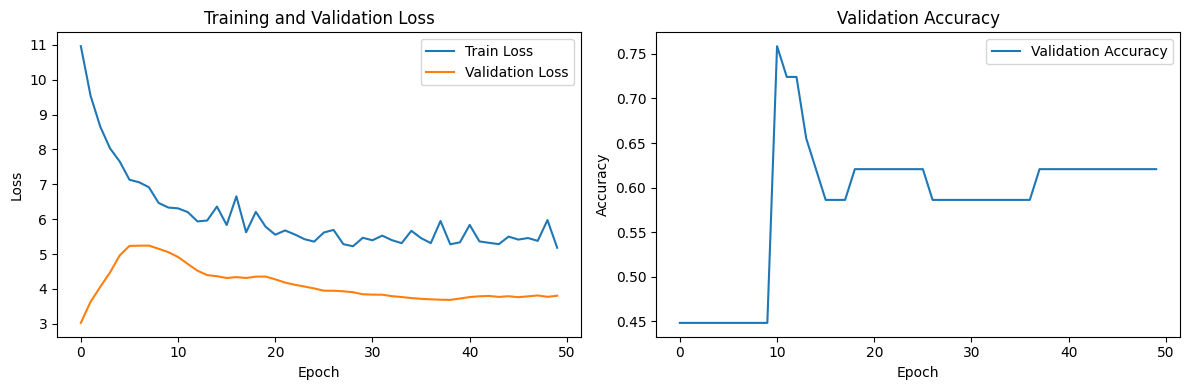

Accuracy: 0.5946

Confusion Matrix:
[[19  1]
 [14  3]]

Classification Report:
              precision    recall  f1-score   support

Poor Quality       0.58      0.95      0.72        20
Good Quality       0.75      0.18      0.29        17

    accuracy                           0.59        37
   macro avg       0.66      0.56      0.50        37
weighted avg       0.66      0.59      0.52        37



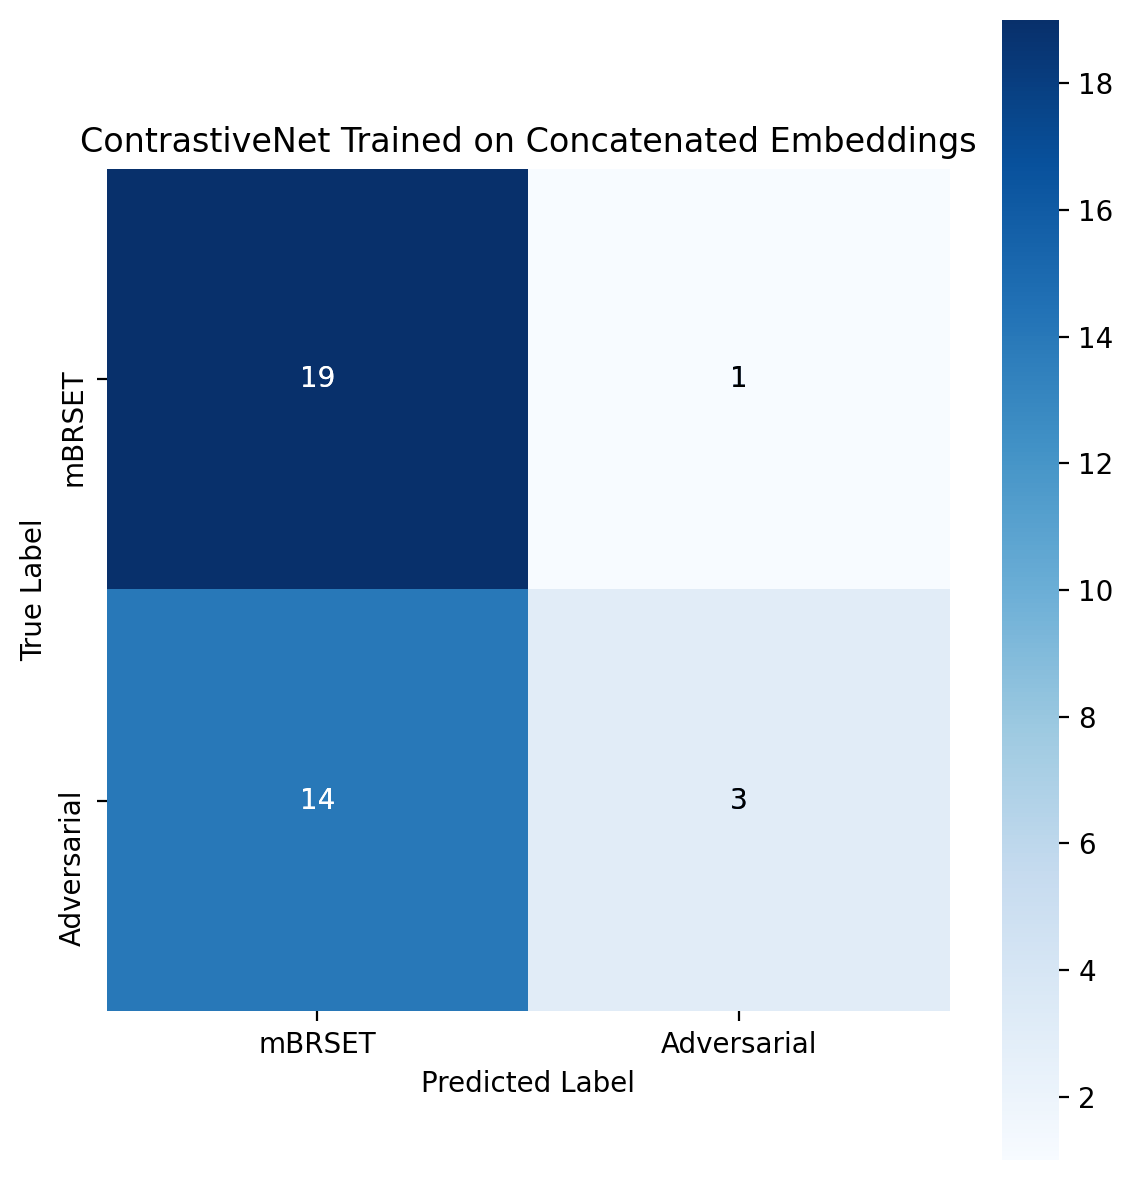

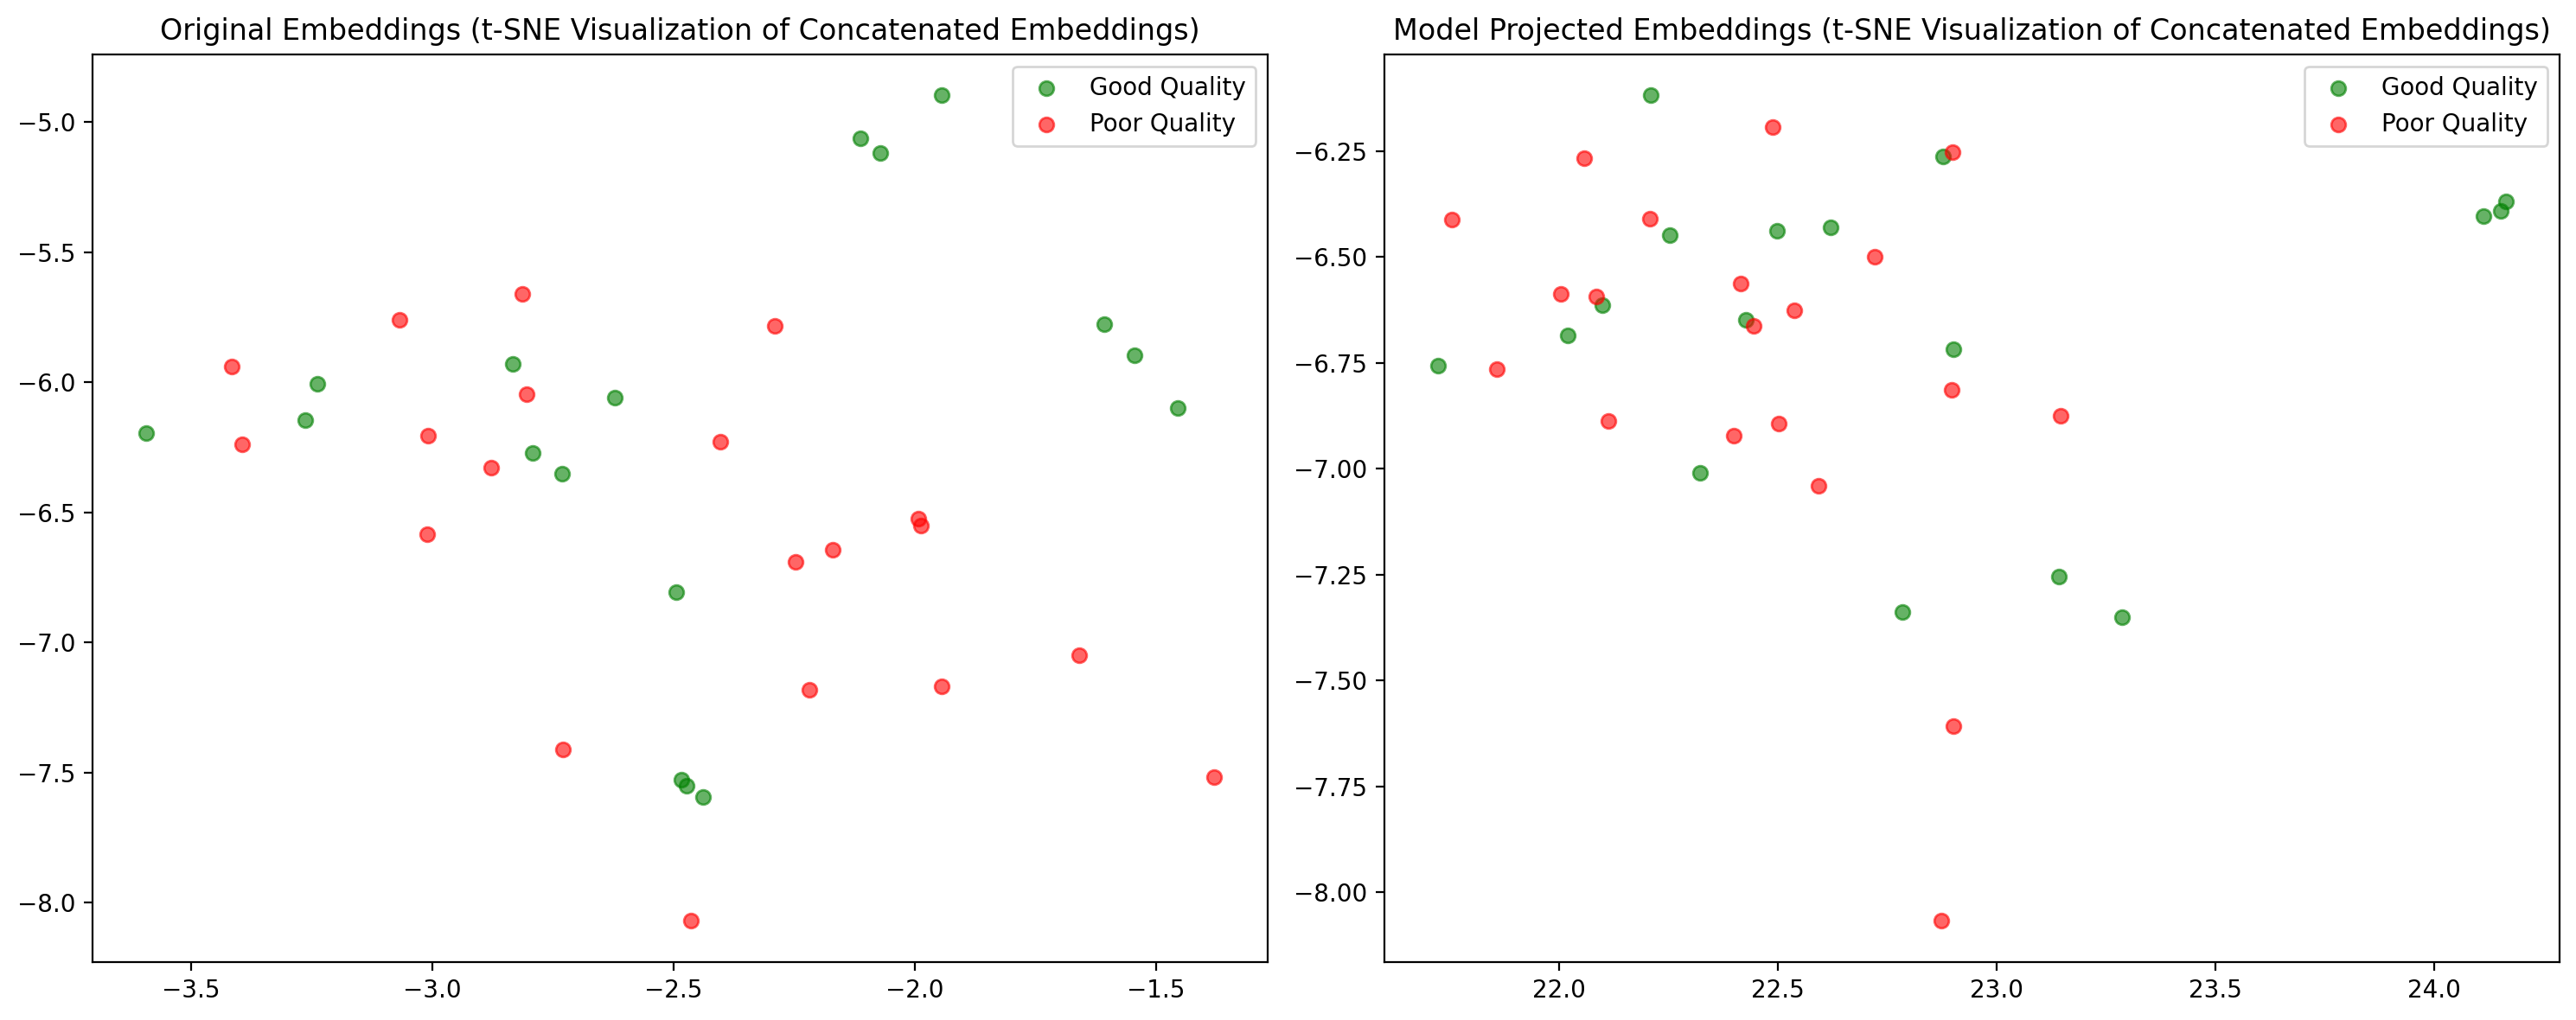

Epoch 10/50, Train Loss: 6.2812, Val Loss: 4.7029, Val Acc: 0.5862
Epoch 20/50, Train Loss: 5.6687, Val Loss: 3.9953, Val Acc: 0.5517
Epoch 30/50, Train Loss: 5.2903, Val Loss: 4.0133, Val Acc: 0.5517
Epoch 40/50, Train Loss: 5.4199, Val Loss: 4.0844, Val Acc: 0.5517
Epoch 50/50, Train Loss: 5.4034, Val Loss: 4.0798, Val Acc: 0.5517


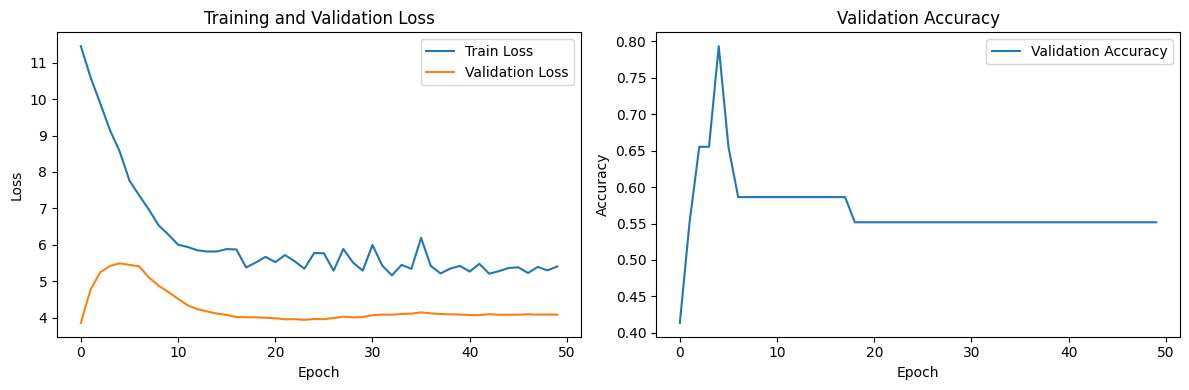

Accuracy: 0.5676

Confusion Matrix:
[[18  2]
 [14  3]]

Classification Report:
              precision    recall  f1-score   support

Poor Quality       0.56      0.90      0.69        20
Good Quality       0.60      0.18      0.27        17

    accuracy                           0.57        37
   macro avg       0.58      0.54      0.48        37
weighted avg       0.58      0.57      0.50        37



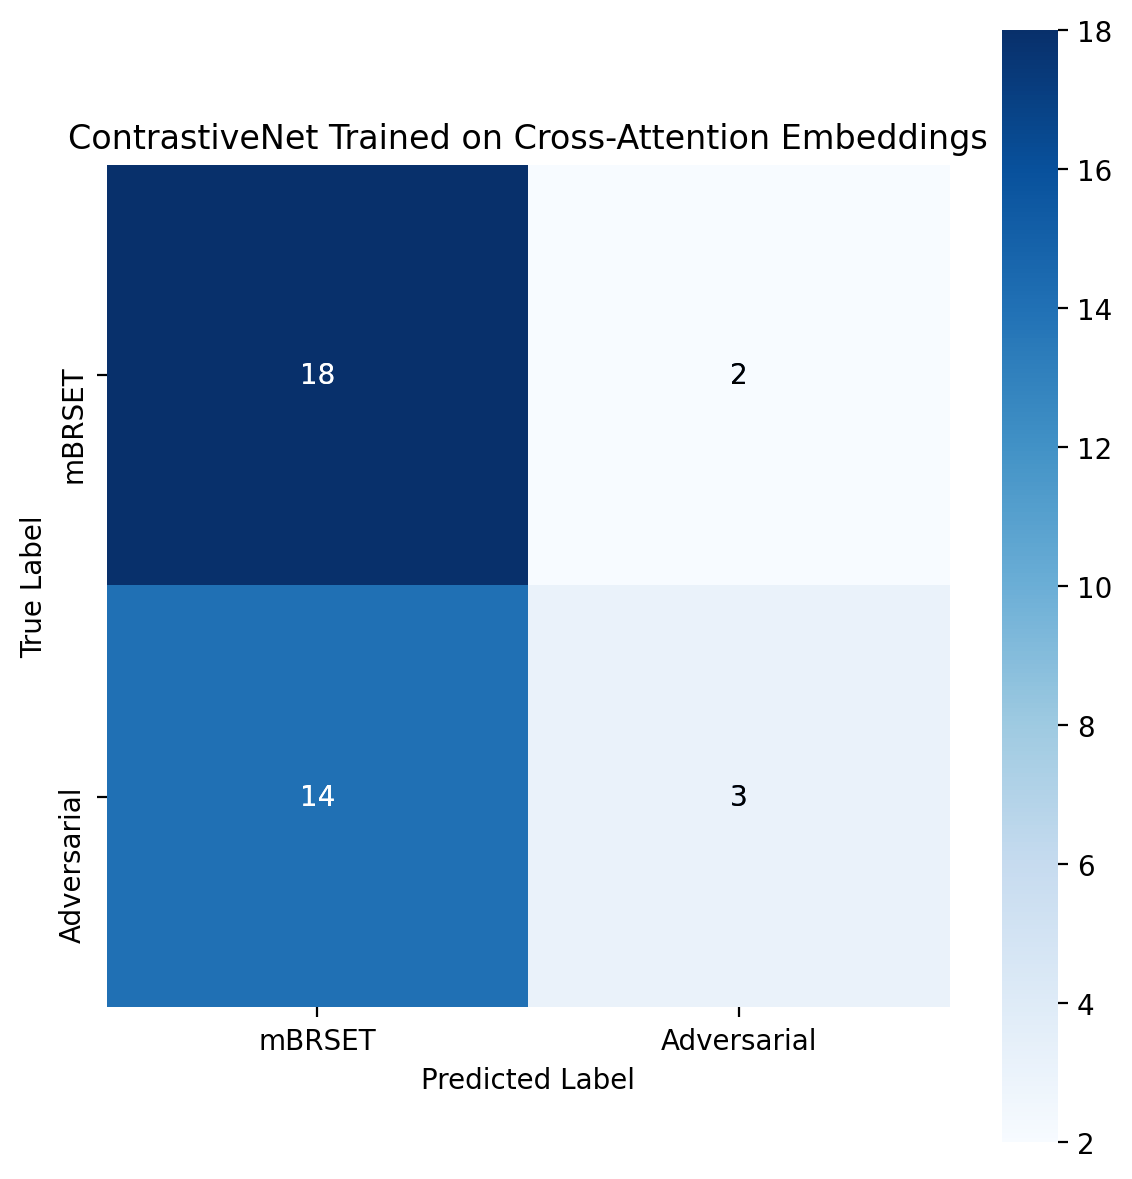

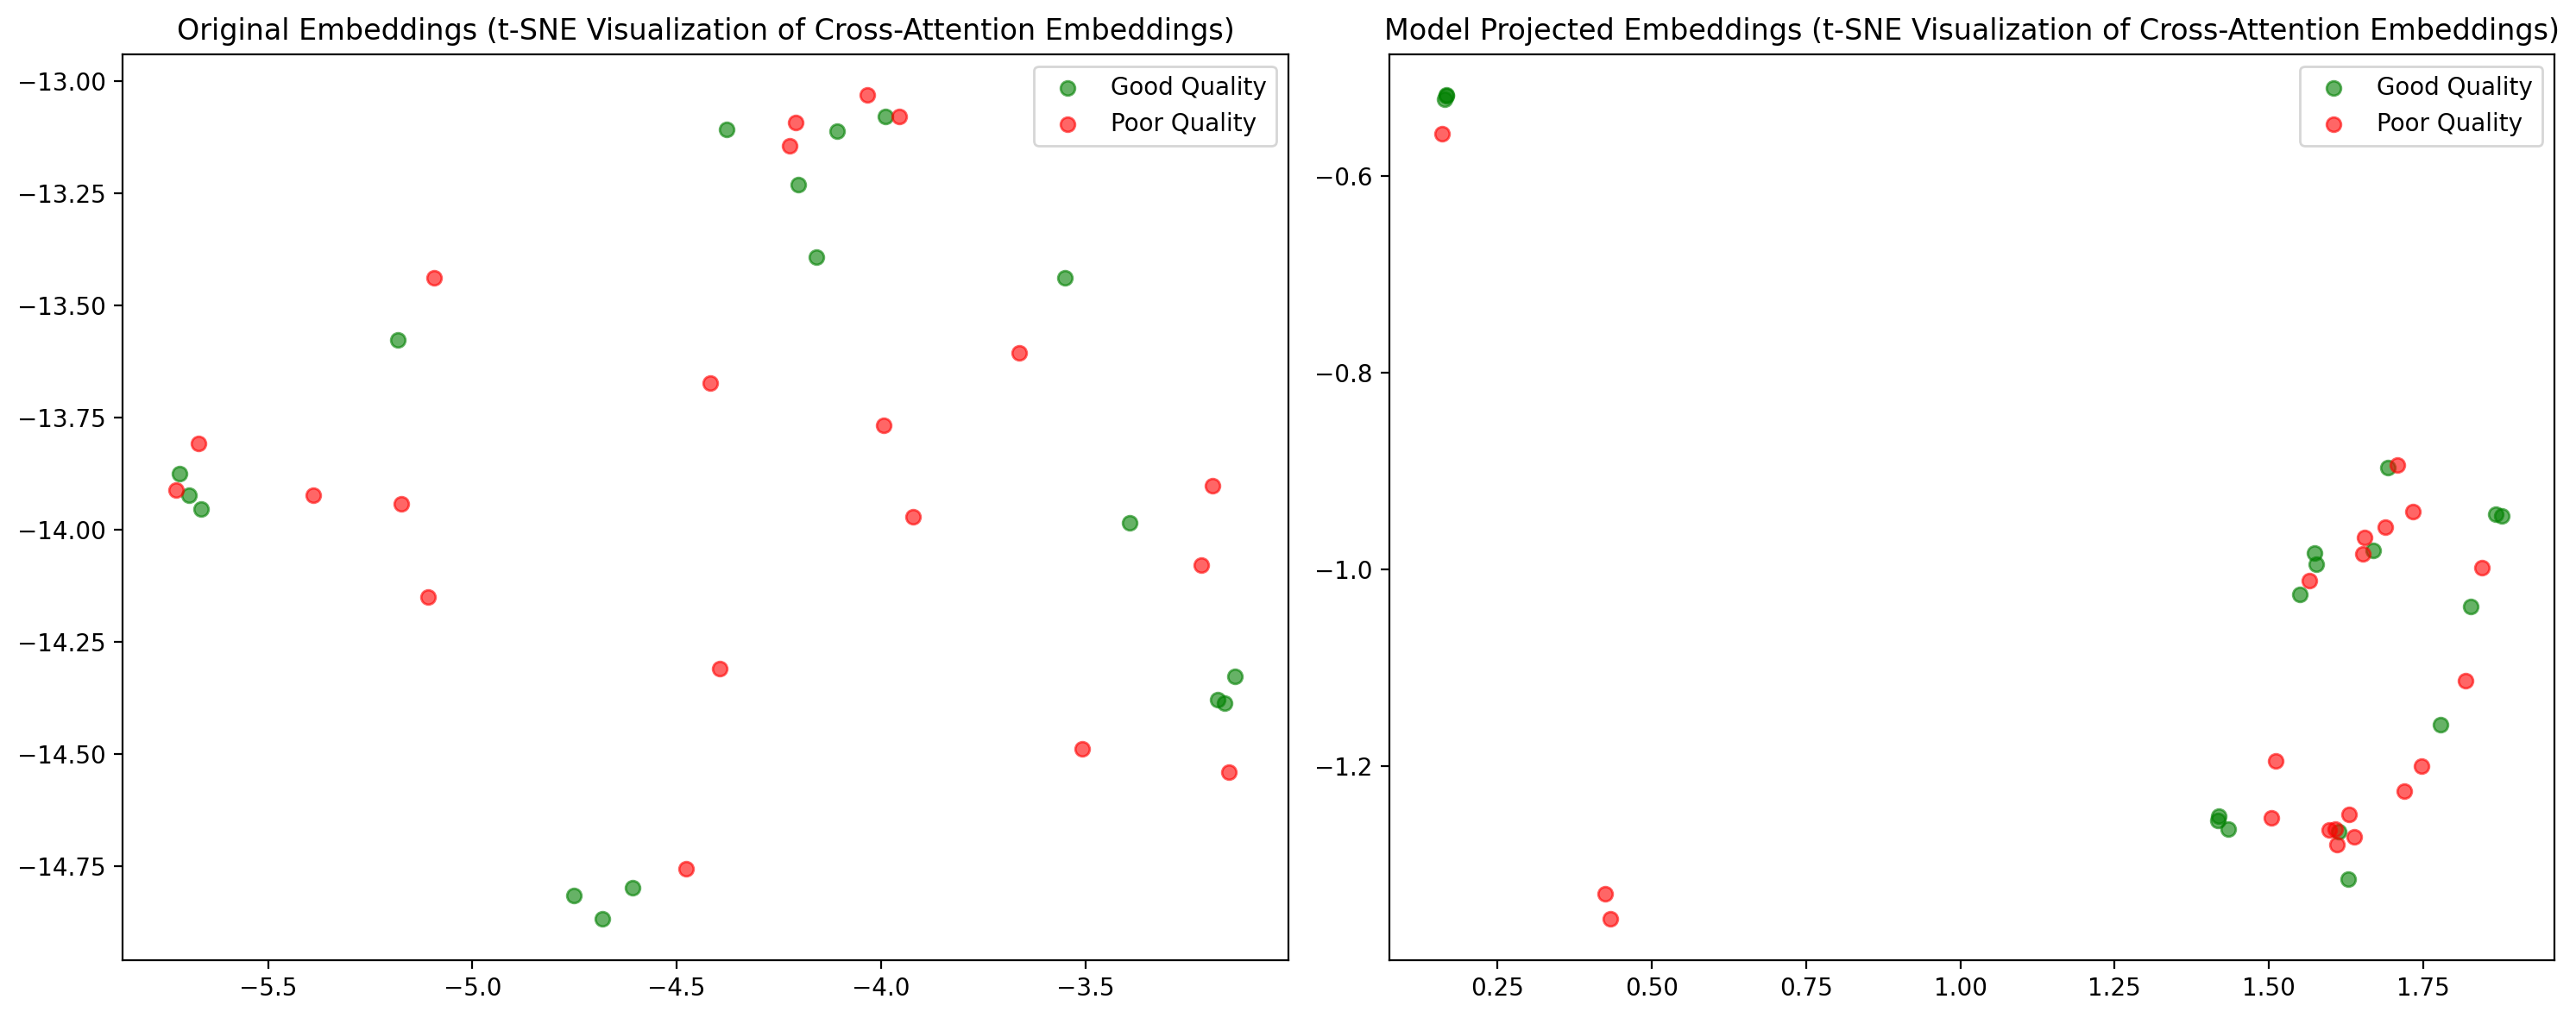

Epoch 10/50, Train Loss: 0.9588, Val Loss: 1.2883, Val Acc: 1.0000
Epoch 20/50, Train Loss: 0.6887, Val Loss: 0.8985, Val Acc: 1.0000
Epoch 30/50, Train Loss: 0.5974, Val Loss: 0.7868, Val Acc: 1.0000
Epoch 40/50, Train Loss: 0.5622, Val Loss: 0.7662, Val Acc: 1.0000
Epoch 50/50, Train Loss: 0.5441, Val Loss: 0.7961, Val Acc: 1.0000


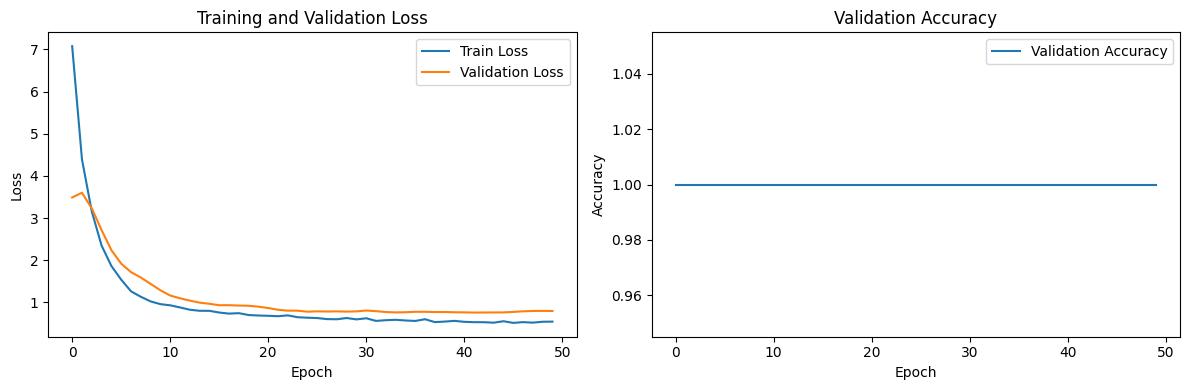

Accuracy: 1.0000

Confusion Matrix:
[[20  0]
 [ 0 17]]

Classification Report:
              precision    recall  f1-score   support

Poor Quality       1.00      1.00      1.00        20
Good Quality       1.00      1.00      1.00        17

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



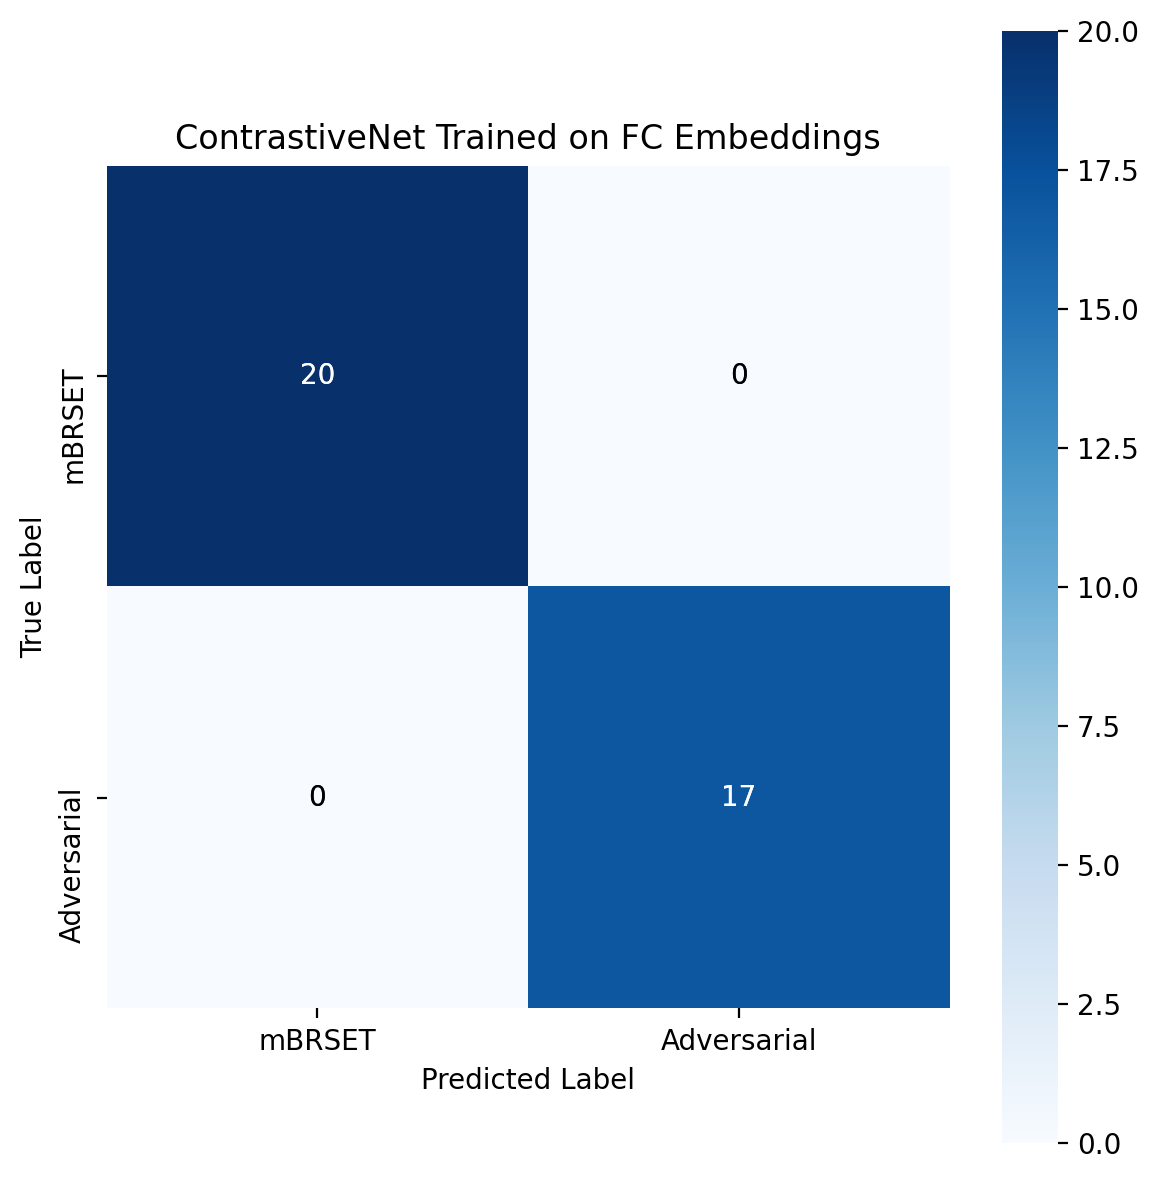

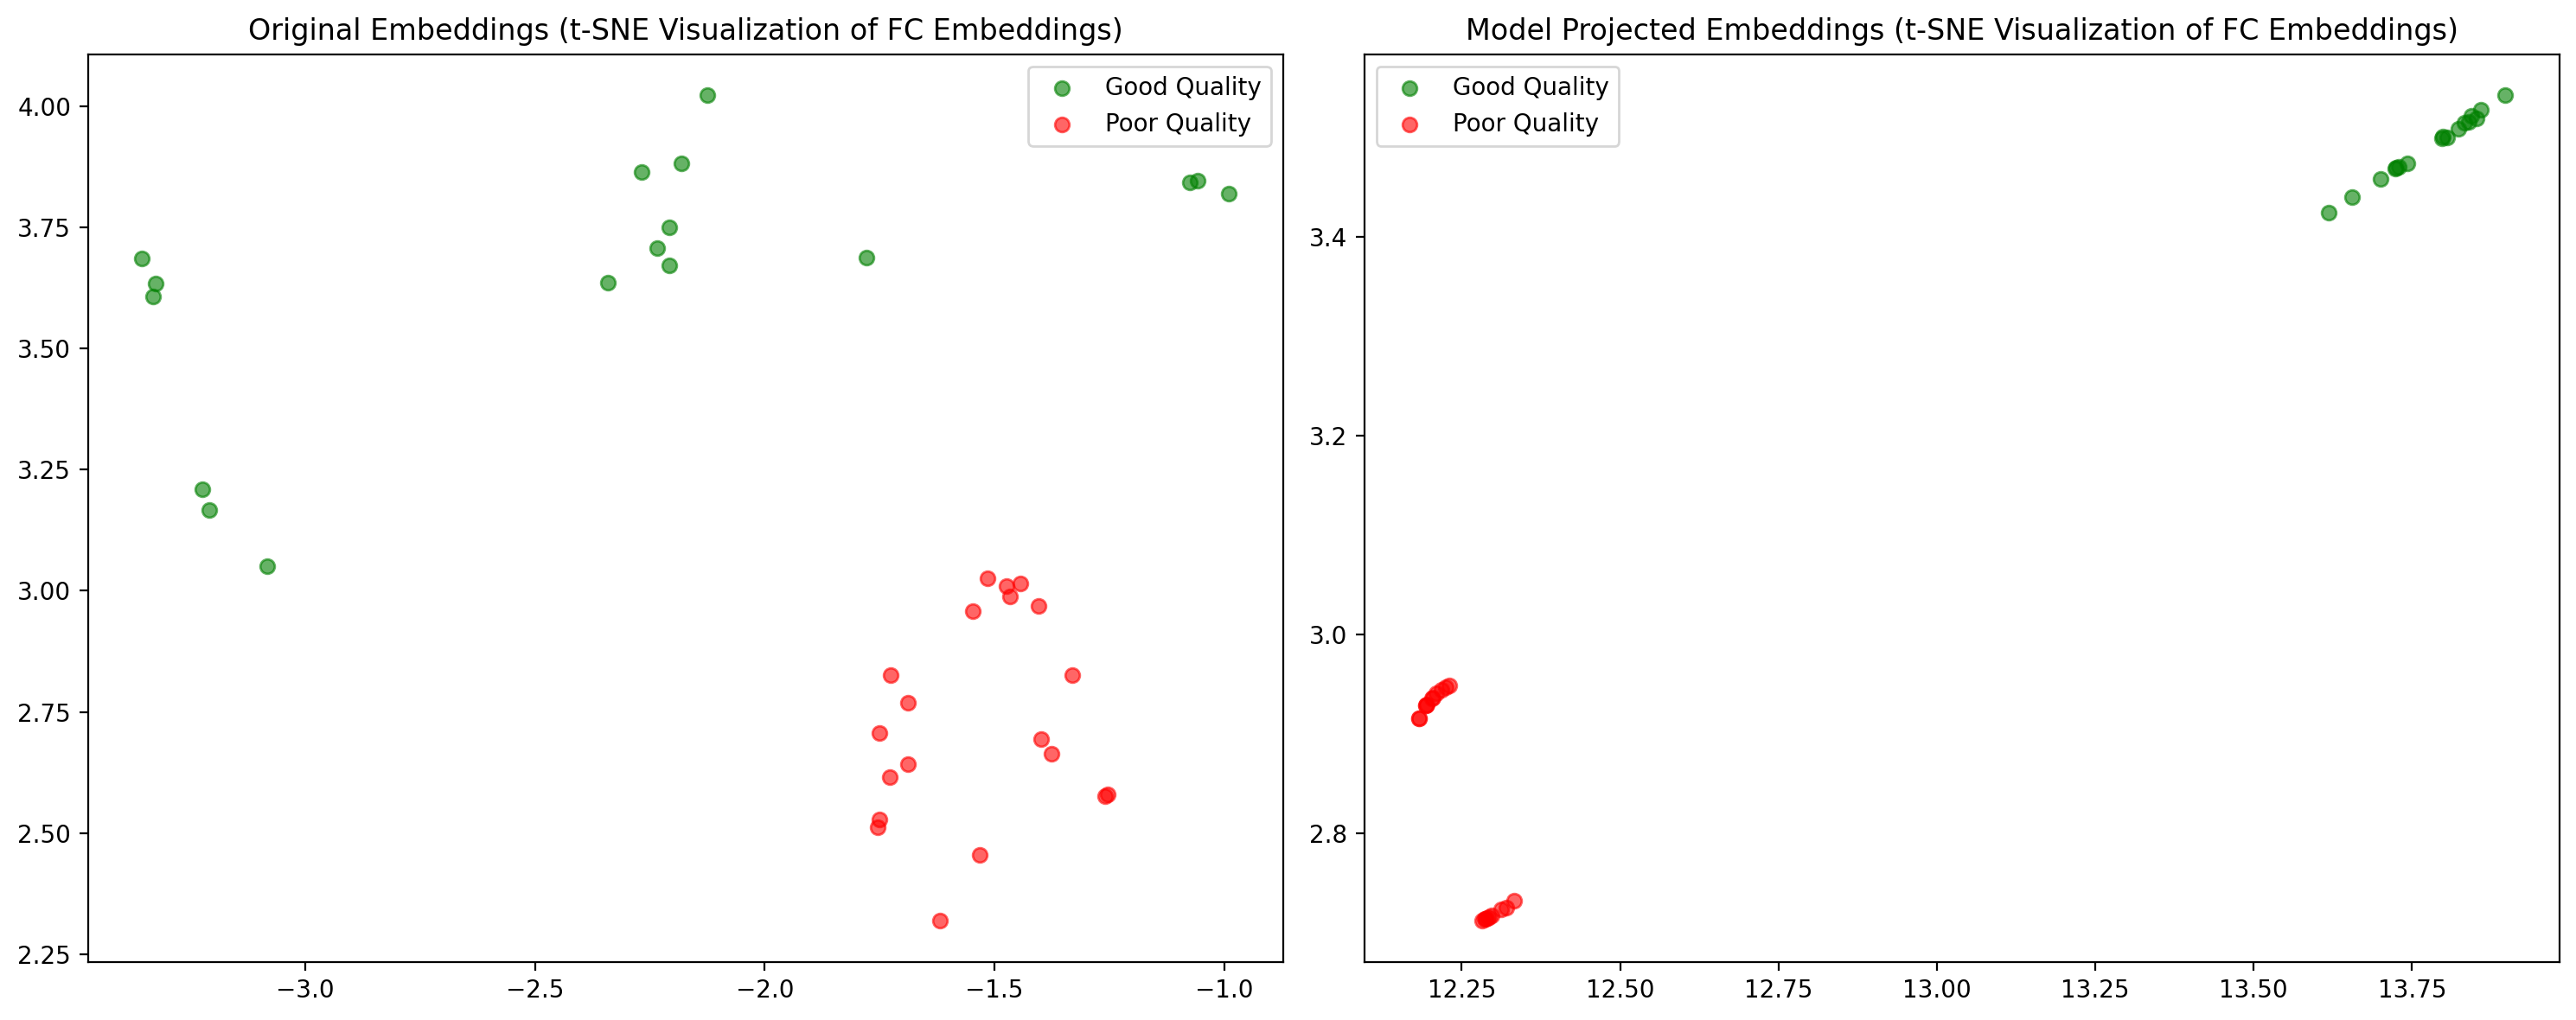

In [30]:
for method, adversarial in zip(['Concatenated', 'Cross-Attention', 'FC'], ['adversarial_concatenation', 'adversarial_cross_attn', 'adversarial_fc']):
    # Initialize and train the model
    classifier = PhotoQualityClassifier(embedding_dim=embedding_dim)
    classifier.train(
        train[method], train[adversarial],
        epochs=50,
        batch_size=64,
        lr=0.001
    )

    # Plot training history
    classifier.plot_training_history()

    # Evaluate the model
    classifier.evaluate(test[method], test[adversarial], method)

    # Visualize embeddings
    classifier.visualize_embeddings(test[method], test[adversarial], method)

# Example of how to use the model with a new embedding
# new_embedding = test['adversarial'][0]
# prob, label = classifier.predict(new_embedding)
# print(f"Prediction for new embedding: Probability = {prob:.4f}, Label = {label}")
# print(f"Class: {'Good Quality' if label == 1 else 'Poor Quality'}")

# Save the model
# classifier.save_model("photo_quality_classifier.pt")